### ML acidoCEST
- Code source: [link](https://scikit-learn.org/0.15/auto_examples/plot_digits_pipe.html)
- Modified by Julio Cardenas-Rodriguez, Ph.D.
- CAMEL West @Tucson, AZ
- License: TBD

Change Log  
- 2018_12_26: Initial Version
- 2019_03_20: Copied to use with new data

### To -do list
1. find importance of each frequency
2. pipeline to PCA ( if needed)
3. Feature selection

#### Logistic Regression

In [1]:
### Libraries
import numpy as np
import pandas as pd
import scikitplot as skplt
import matplotlib.pyplot as plt

from sklearn import linear_model, decomposition, datasets
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn import metrics

### Load data for polymer
data_file ='../data/raw/CEST-ML-format_mdp_20181121_230pm_JCR_CJK_20190320.xlsx'

df         = pd.read_excel(data_file, sheetname='Polymer')

c = ['Sample ID','pH','concentration_mM','temperature_C','sat time_sec','sat power_uT']
meta = df[c]

### Get only frequencies without a NaN (re-write to avodi doing it by hand)
data = df.drop(c,axis = 1)
cols = data.columns[np.abs(data.columns.values) <= 14]
X = data[cols]
pH = meta['pH']

In [2]:
### define function to train model based on cuttoff for pH
def train_logistic_regression_pipeline(Spectra, pH_observed, pH_cut_off = 7.0, n_cs=20):
    # cut off > pH
    y = 1*(pH_observed > pH_cut_off)
    # X data
    X = Spectra.copy()
        
    # 2-PCA
    logistic = linear_model.LogisticRegression(solver='liblinear', penalty='l1',max_iter=500)

    
    # Training parameters
    num_pca_components = np.arange(1,45,1)
    Cs = np.logspace(-3, 2, n_cs)

    # Grid Search on Pipeline
    estimator = GridSearchCV(logistic,
                         dict(
                              C= Cs,
                              class_weight= ['balanced',None],
                              fit_intercept= [True,False]), 
                             verbose = 1, cv = 3, n_jobs=3, iid = True)
    
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

    # Grid Search of Model
    estimator.fit(X_train, y_train)
    
    # training
    print('TRAINING')
    print('----'*10)
    print(metrics.classification_report( estimator.predict(X_train), y_train))

    # testing
    print('TESTING')
    print('----'*10)
    print(metrics.classification_report( estimator.predict(X_test), y_test))
    
    #Confusion
    skplt.metrics.plot_confusion_matrix(y_test, estimator.predict(X_test), normalize=True)
    plt.show()
    
    return estimator.best_estimator_, X_train, X_test, y_train, y_test

In [4]:
d = meta[['pH', 'concentration_mM','temperature_C','sat time_sec',     'sat power_uT']]

for C in d.columns:  
    print(d[C].nunique(), C + ' unique values')
    print('--'*10)

15 pH unique values
--------------------
10 concentration_mM unique values
--------------------
7 temperature_C unique values
--------------------
7 sat time_sec unique values
--------------------
7 sat power_uT unique values
--------------------


Note on metrics
- precision = positive predictive value
- recall    = sensitivity

### pH >7.0

In [5]:
(pH> 7).value_counts(normalize = True).round(2)

False    0.53
True     0.47
Name: pH, dtype: float64

## -training

Fitting 3 folds for each of 40 candidates, totalling 120 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done 120 out of 120 | elapsed:   25.8s finished


TRAINING
----------------------------------------
              precision    recall  f1-score   support

           0       1.00      0.92      0.96       183
           1       0.90      1.00      0.95       132

   micro avg       0.96      0.96      0.96       315
   macro avg       0.95      0.96      0.95       315
weighted avg       0.96      0.96      0.96       315

TESTING
----------------------------------------
              precision    recall  f1-score   support

           0       0.99      0.88      0.93        80
           1       0.84      0.98      0.91        55

   micro avg       0.92      0.92      0.92       135
   macro avg       0.91      0.93      0.92       135
weighted avg       0.93      0.92      0.92       135



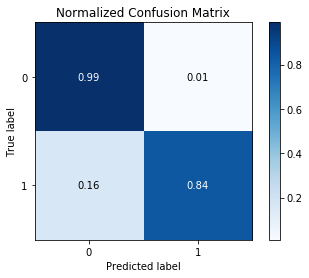

In [6]:
clf_01, Xtrain, Xtest, ytrain, ytest = train_logistic_regression_pipeline(X.replace(np.nan,1), pH,
                                                                          pH_cut_off = 7.0, n_cs=10 )

## offset importance

In [7]:
d = pd.DataFrame( index =Xdata.columns.values.flatten(), 
                  data = clf_01.coef_.flatten(), 
                  columns=['c'])
print('L1 logistic regression selected these offsets:',d[d.c != 0].shape)
d[d.c != 0]

NameError: name 'Xdata' is not defined

## repeat with only a few freq

In [8]:
clf_01, Xtrain, Xtest, ytrain, ytest = train_logistic_regression_pipeline(Xdata[d[d.c != 0].index], pH,
                                                                          pH_cut_off = 7.0, n_cs=10 )

NameError: name 'Xdata' is not defined

### pH > 6.8

In [ ]:
(pH > 6.8).value_counts(normalize = True).round(2)

In [ ]:
clf_02, Xtrain, Xtest, ytrain, ytest = train_logistic_regression_pipeline(Xdata,
                                                                          pH,  pH_cut_off = 6.8, n_cs=10 )

In [ ]:
d = pd.DataFrame( index =Xdata.columns.values.flatten(), 
                  data = clf_02.coef_.flatten(), 
                  columns=['c'])
print('L1 logistic regression selected these offsets:',d[d.c != 0].shape)
d[d.c != 0]

In [ ]:
clf_02b, Xtrain, Xtest, ytrain, ytest = train_logistic_regression_pipeline(Xdata[d[d.c != 0].index], pH,
                                                                          pH_cut_off = 7.0, n_cs=10 )